In [14]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import scipy.io as sio
import matplotlib.pyplot as plt
from skimage.transform import resize
from sklearn.preprocessing import MinMaxScaler

NX, NY, NZ = 160, 160, 5

***

In [178]:
dd = sio.loadmat('states/states_307.mat', simplify_cells=True)['var']
dd[0].keys()

dict_keys(['pressure', 's', 's3d', 't', 'dT', 'wellSol', 'totVol', 'vol', 'freeVol', 'trappedVol', 'leakedVol'])

In [179]:
totVol = []
vol = []
freeVol = []
trappedVol = []
leakedVol = []
timesteps = []

for i in tqdm(range(1, 60)):
    d = dd[i]
    totVol.append(d['totVol'])
    vol.append(d['vol'])
    freeVol.append(d['freeVol'])
    trappedVol.append(d['trappedVol'])
    leakedVol.append(d['leakedVol'])
    timesteps.append(d['t'])
vol = np.array(vol)

100%|██████████| 59/59 [00:00<00:00, 196399.95it/s]


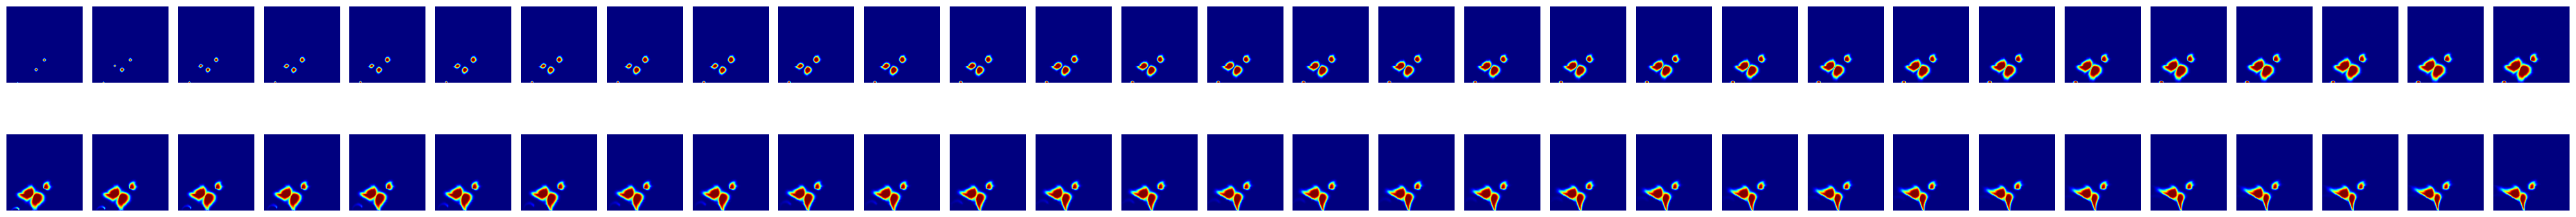

In [180]:
plt.figure(figsize=(40,5))
for i in range(60):
    plt.subplot(2, 30, i+1)
    plt.imshow(dd[i]['s'].reshape(NX,NY), cmap='jet')
    plt.axis('off')
plt.tight_layout()
plt.show()

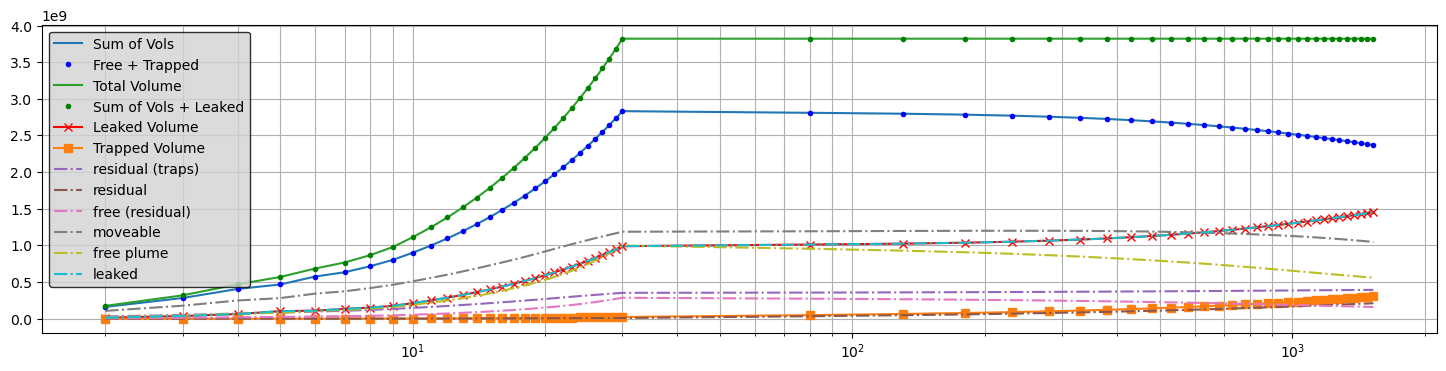

In [181]:
vols = np.hstack([vol, np.array(leakedVol).reshape(-1,1)])
trapped_labels = ['residual (traps)', 'residual', 'free (residual)', 'moveable', 'free plume', 'leaked']

plt.figure(figsize=(18,4))
plt.plot(timesteps, np.sum(vol, 1), label='Sum of Vols', c='tab:blue')
plt.plot(timesteps, np.sum([freeVol, trappedVol], 0), label='Free + Trapped', ls='', marker='.', c='b')

plt.plot(timesteps, totVol, label='Total Volume', c='tab:green')
plt.plot(timesteps, np.sum(vol,1)+leakedVol, label='Sum of Vols + Leaked', ls='', marker='.', c='g')

plt.plot(timesteps, leakedVol, label='Leaked Volume', c='r', marker='x')
plt.plot(timesteps, trappedVol, label='Trapped Volume', c='tab:orange', marker='s')

for k in range(6):
    plt.plot(timesteps, vols[:,k], label=trapped_labels[k], ls='-.', c='C{}'.format(k+4))

plt.legend(facecolor='lightgrey', edgecolor='k', loc='upper left')
plt.xscale('log')
plt.grid(True, which='both')

plt.show()